# Исследование датасетов trashnet и trashnet_enhanced & Создание с помощью них модели классификации мусора

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat
import io

## Загрузка данных

In [ ]:
# Функция для загрузки датасета в формате parquet
def get_df_from_hf_parquet(base_url: str, parquet_count: int) -> pd.DataFrame:
  urls = [base_url + f"{i:04}.parquet" for i in range(0, parquet_count)]
  return pd.concat([pd.read_parquet(url) for url in urls])

### Загрука базового trashnet

In [ ]:
base_url = "https://huggingface.co/datasets/garythung/trashnet/resolve/refs%2Fconvert%2Fparquet/default/train/"

df_base = get_df_from_hf_parquet(base_url, 4)

### Загрузка улучшенного trashnet

In [ ]:
enhanced_url = "https://huggingface.co/datasets/edwinpalegre/trashnet_enhanced/resolve/refs%2Fconvert%2Fparquet/default/train/"

df_enhanced = get_df_from_hf_parquet(enhanced_url, 100)

## Создание колонок с названиями классов

In [ ]:
label_mapping_base = {
    0: "GLASS",
    1: "PAPER",
    2: "CARDBOARD",
    3: "PLASTIC",
    4: "METAL",
    5: "TRASH"
}

label_mapping_enhanced = {
    0: "BIODEGRADABLE",
    1: "CARDBOARD",
    2: "GLASS",
    3: "METAL",
    4: "PAPER",
    5: "PLASTIC",
    6: "TRASH"
}

In [ ]:
df_base["label_name"] = df_base["label"].map(label_mapping_base)
df_base

,image,label,label_name
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,GLASS
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,GLASS
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,GLASS
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,GLASS
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,GLASS
...,...,...,...
2049,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,TRASH
2050,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,TRASH
2051,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,TRASH
2052,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,TRASH


In [ ]:
df_enhanced["label_name"] = df_enhanced["label"].map(label_mapping_enhanced)
df_enhanced

,image,label,label_name
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,BIODEGRADABLE
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,BIODEGRADABLE
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,BIODEGRADABLE
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,BIODEGRADABLE
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,BIODEGRADABLE
...,...,...,...
193,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,TRASH
194,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,TRASH
195,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,TRASH
196,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,TRASH


## EDA

In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5054 entries, 0 to 2053
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5054 non-null   object
 1   label       5054 non-null   int64 
 2   label_name  5054 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.9+ KB


In [ ]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19892 entries, 0 to 197
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       19892 non-null  object
 1   label       19892 non-null  int64 
 2   label_name  19892 non-null  object
dtypes: int64(1), object(2)
memory usage: 621.6+ KB


**Описание столбцов**


* **image**: Файл изображения
* **label**: Численное значение типа мусора
* **label_name**: Название типа мусора

### 1. Баланс датасета. График покажет количество изображений в каждом классе.

In [ ]:
df_base["label_name"].value_counts().sort_index()
df_enhanced["label_name"].value_counts().sort_index()

,count
label_name,
BIODEGRADABLE,3692
CARDBOARD,2782
GLASS,4902
METAL,2484
PAPER,3485
PLASTIC,2410
TRASH,137


<ipython-input-12-5149e800b48d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_base, palette="viridis", order=order)


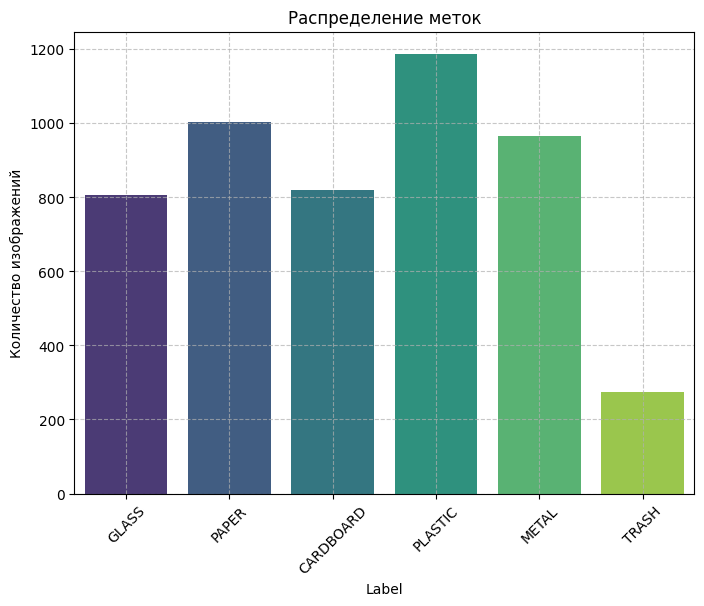

In [ ]:
plt.figure(figsize=(8, 6))
order = sorted(df_base["label"].unique())
sns.countplot(x="label", data=df_base, palette="viridis", order=order)
plt.xticks(ticks=order, labels=[label_mapping_base[i] for i in order])
plt.title("Распределение меток")
plt.xlabel("Label")
plt.ylabel("Количество изображений")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Вывод: Дисбаланс наблюдается и может потребоваться применение методов балансировки данных.**

<ipython-input-13-acfdae146cdf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_enhanced, palette="viridis", order=order)


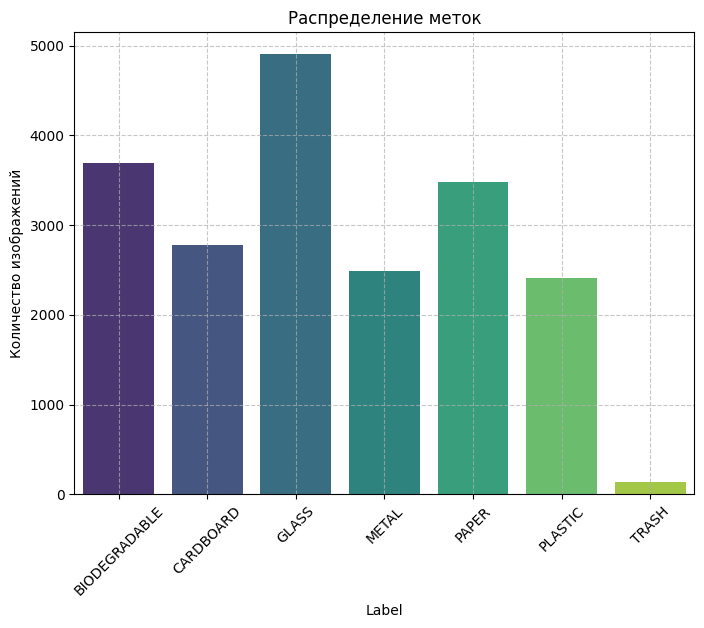

In [ ]:
plt.figure(figsize=(8, 6))
order = sorted(df_enhanced["label"].unique())
sns.countplot(x="label", data=df_enhanced, palette="viridis", order=order)
plt.xticks(ticks=order, labels=[label_mapping_enhanced[i] for i in order])
plt.title("Распределение меток")
plt.xlabel("Label")
plt.ylabel("Количество изображений")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Вывод: В отличие от базового датасета в улучшенном добавлен еще один класс "BIODEGRADABLE". Что улучшит гибкость будущей модели. Дисбаланс также наблюдается и может потребоваться применение методов балансировки данных.**

### 2. Оценить визуальные различия между классами. Показываем по одному примеру из каждого класса

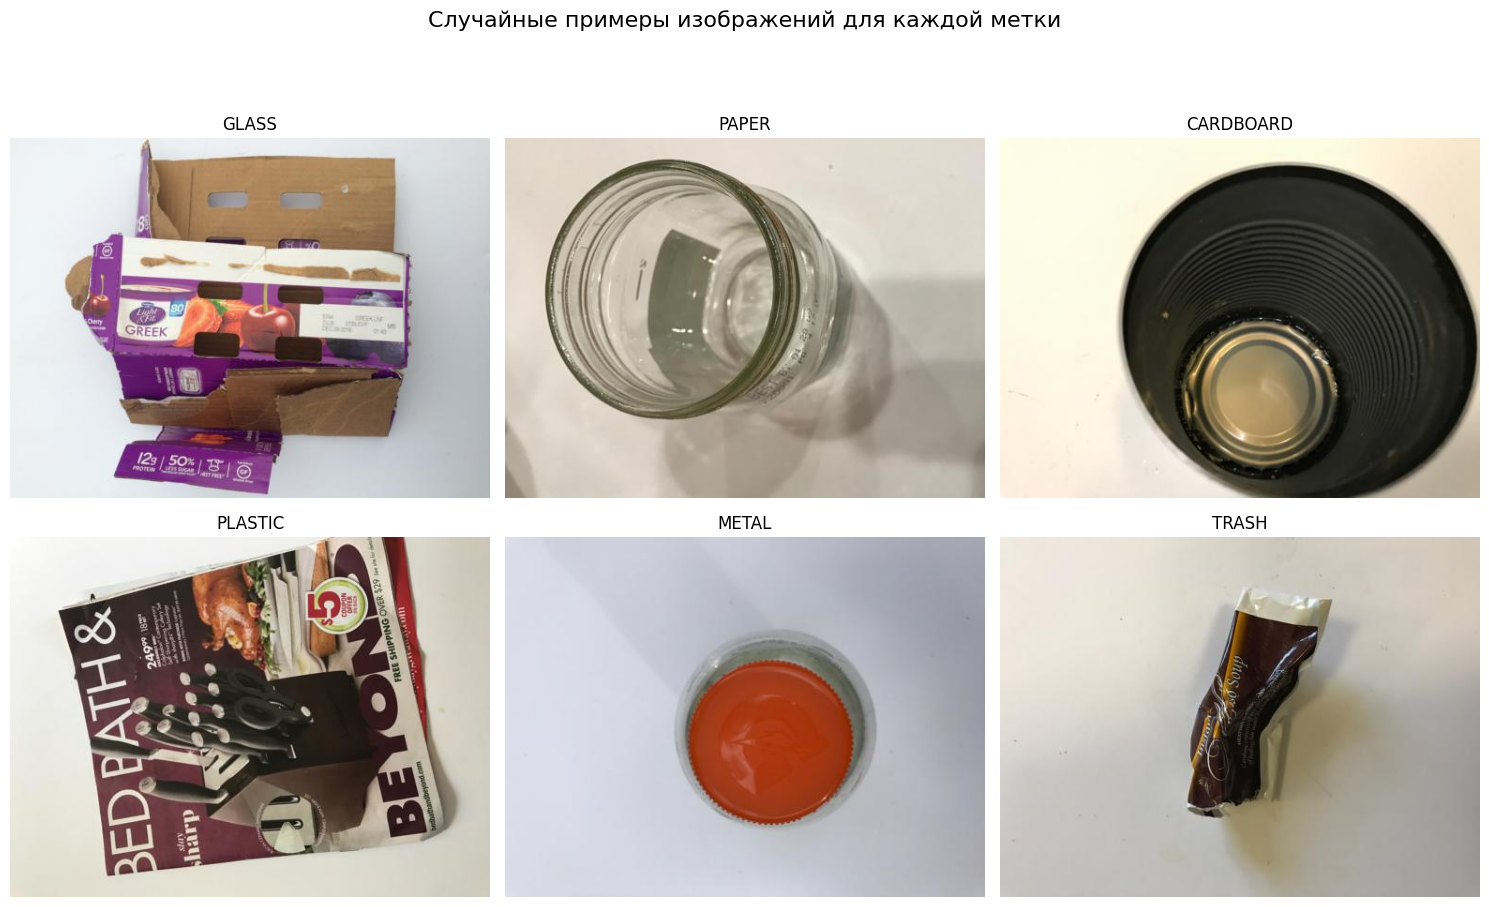

In [ ]:
unique_labels = sorted(df_base["label"].unique())
plt.figure(figsize=(15, 10))

for idx, label in enumerate(unique_labels):
    # Выбираем случайное изображение для текущей метки
    sample = df_base[df_base["label"] == label].sample(1).iloc[0]
    image_info = sample["image"]

    # Открываем изображение из байтов
    img = Image.open(io.BytesIO(image_info["bytes"]))

    plt.subplot(2, 3, idx+1)
    plt.imshow(img)
    plt.title(label_mapping_base[label])
    plt.axis("off")

plt.suptitle("Случайные примеры изображений для каждой метки", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Вывод: Классы схожи визуально, модель может испытывать трудности в их различении**

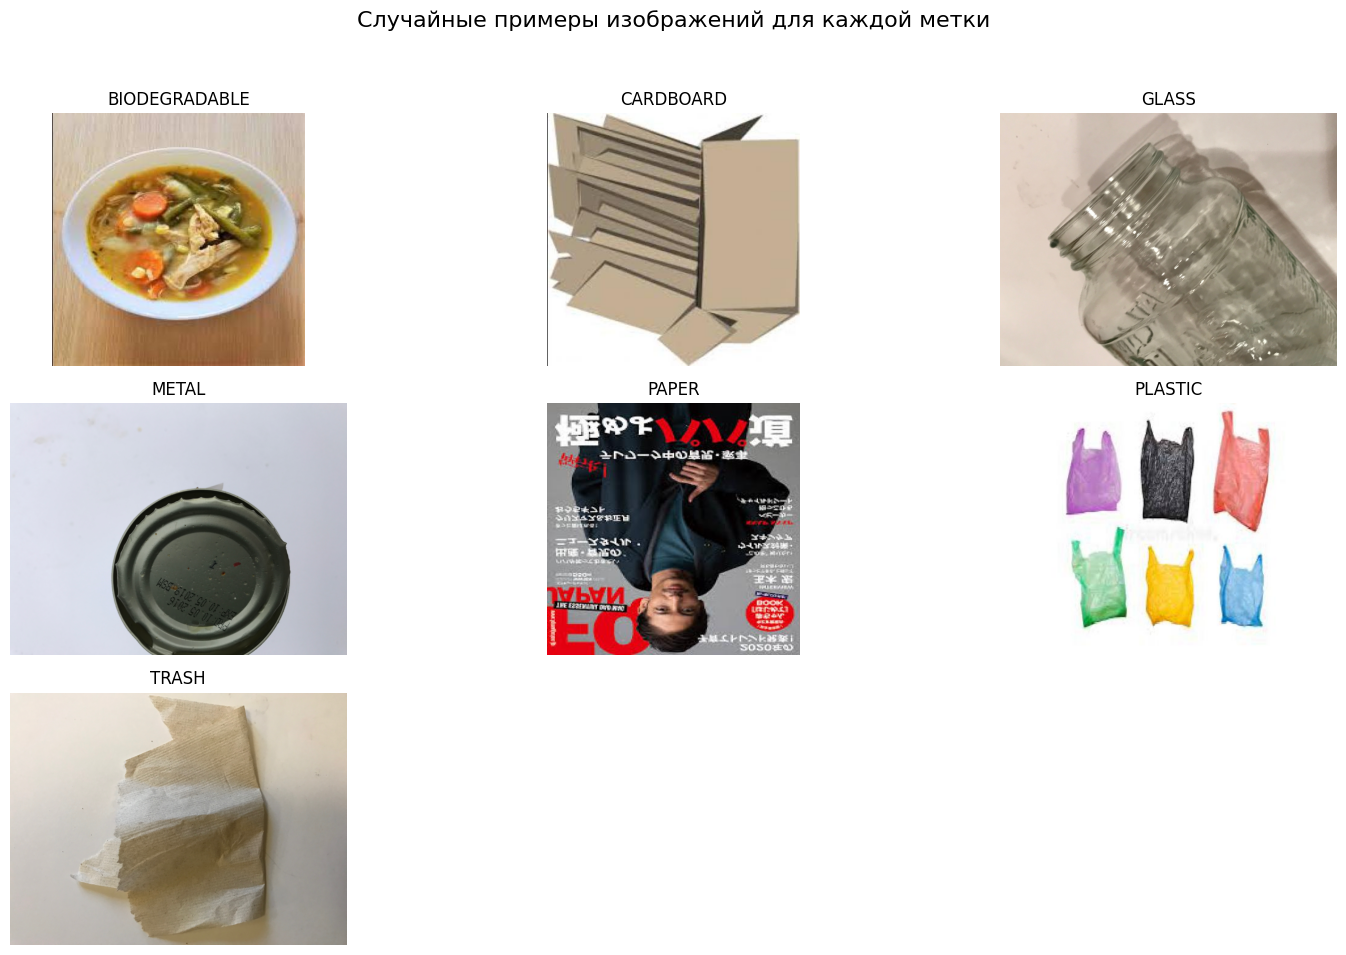

In [ ]:
unique_labels = sorted(df_enhanced["label"].unique())
plt.figure(figsize=(15, 10))

for idx, label in enumerate(unique_labels):
    # Выбираем случайное изображение для текущей метки
    sample = df_enhanced[df_enhanced["label"] == label].sample(1).iloc[0]
    image_info = sample["image"]

    # Открываем изображение из байтов
    img = Image.open(io.BytesIO(image_info["bytes"]))

    plt.subplot(3, 3, idx+1)
    plt.imshow(img)
    plt.title(label_mapping_enhanced[label])
    plt.axis("off")

plt.suptitle("Случайные примеры изображений для каждой метки", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Вывод: Классы схожи визуально, модель может испытывать трудности в их различении**

### 3. Анализируем размеры изображений

#### Извлекаем размеры изображений

In [ ]:
df_base["width"] = df_base["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).width)
df_base["height"] = df_base["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).height)

In [ ]:
df_base["width"].describe()

,width
count,5054.000000
mean,2216.686981
std,1715.488657
min,512.000000
25%,512.000000
50%,1888.000000
75%,4032.000000
max,4032.000000


In [ ]:
df_base["height"].describe()

,height
count,5054.000000
mean,1662.515235
std,1286.616493
min,384.000000
25%,384.000000
50%,1416.000000
75%,3024.000000
max,3024.000000


In [ ]:
df_enhanced["width"] = df_enhanced["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).width)
df_enhanced["height"] = df_enhanced["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).height)

In [ ]:
df_enhanced["width"].describe()

,width
count,19892.000000
mean,861.308667
std,1171.315912
min,416.000000
25%,416.000000
50%,416.000000
75%,416.000000
max,4032.000000


In [ ]:
df_enhanced["height"].describe()

,height
count,19892.000000
mean,736.769757
std,843.974277
min,416.000000
25%,416.000000
50%,416.000000
75%,416.000000
max,3024.000000


#### Строим графики

<ipython-input-22-9e3a8977a30d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_base["width"], ax=axes[0], palette="viridis")
<ipython-input-22-9e3a8977a30d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_base["height"], ax=axes[1], palette="magma")


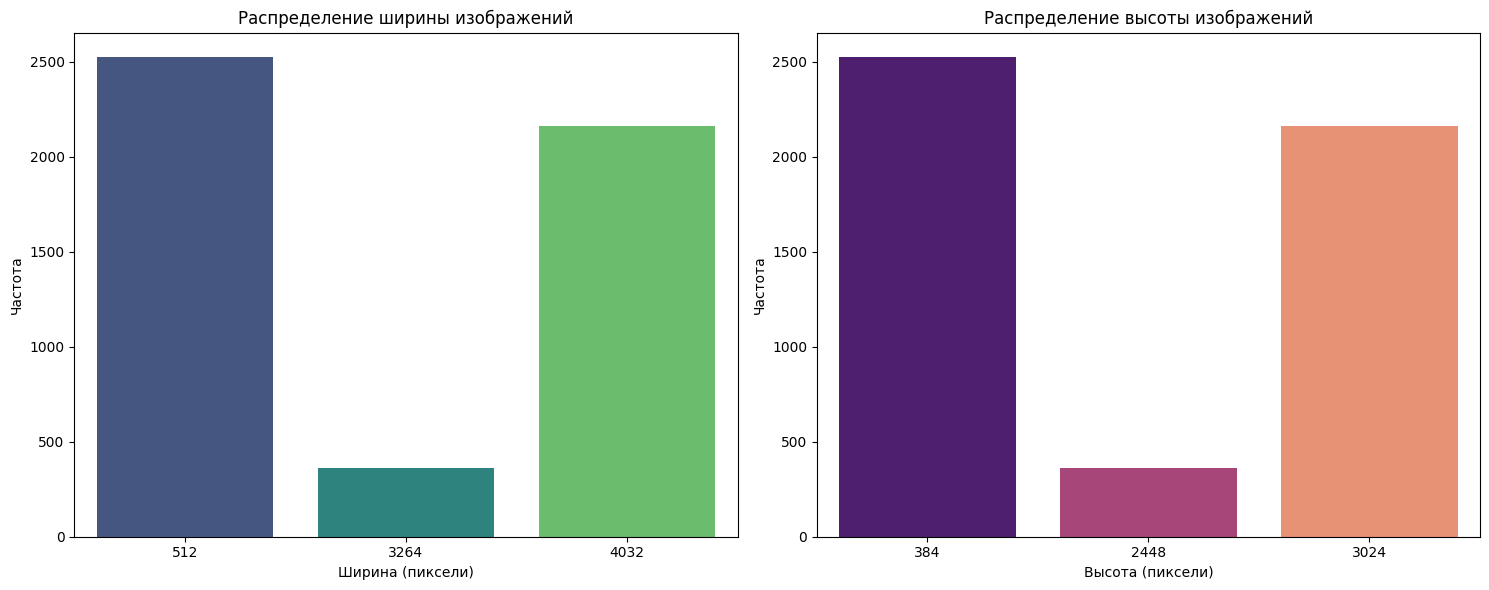

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Создаём фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Барплот для ширины изображений
sns.countplot(x=df_base["width"], ax=axes[0], palette="viridis")
axes[0].set_title("Распределение ширины изображений")
axes[0].set_xlabel("Ширина (пиксели)")
axes[0].set_ylabel("Частота")

# Барплот для высоты изображений
sns.countplot(x=df_base["height"], ax=axes[1], palette="magma")
axes[1].set_title("Распределение высоты изображений")
axes[1].set_xlabel("Высота (пиксели)")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


**Выводы: Изображения сильно различаются по размеру, может потребоваться их обрезка или масштабирование до одного размера. Например, если в датасете есть изображения с крайне высокими или широкими пропорциями, их можно скорректировать для унификации.**

<ipython-input-23-fdad1c4cabc8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_enhanced["width"], ax=axes[0], palette="viridis")
<ipython-input-23-fdad1c4cabc8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_enhanced["height"], ax=axes[1], palette="magma")


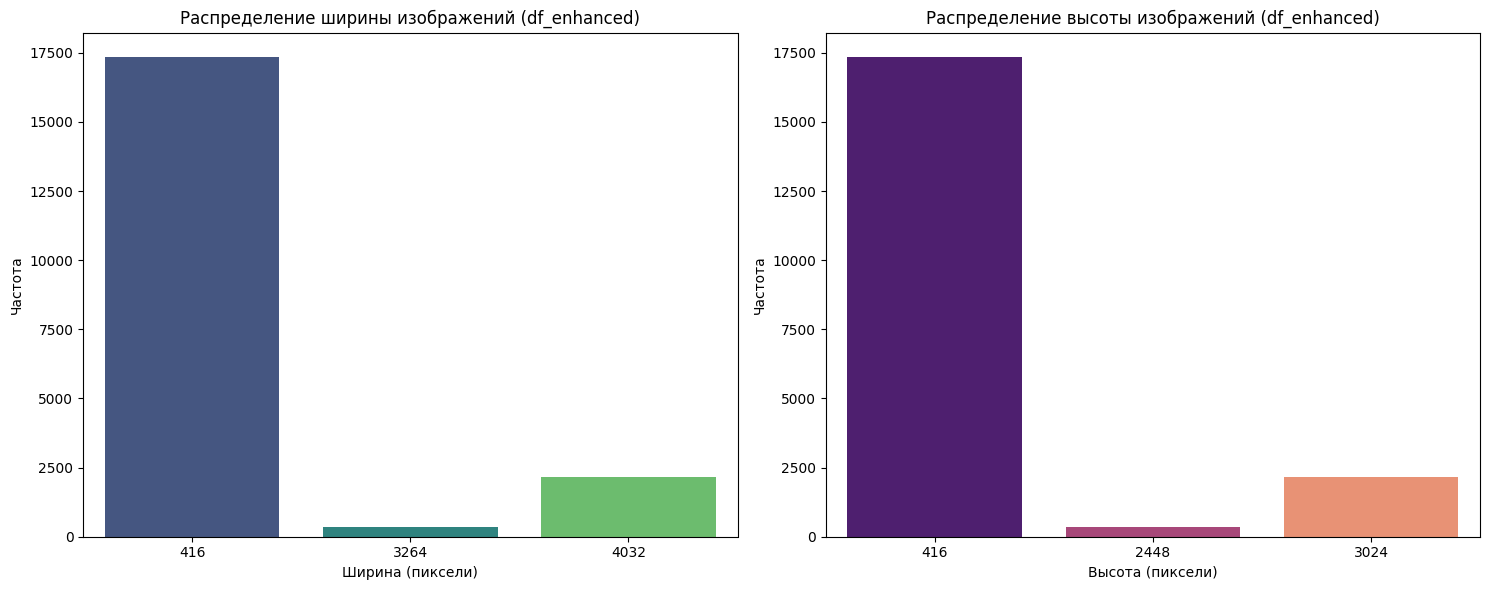

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import io

# Создаём фигуру с двумя графиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Барплот для ширины изображений
sns.countplot(x=df_enhanced["width"], ax=axes[0], palette="viridis")
axes[0].set_title("Распределение ширины изображений (df_enhanced)")
axes[0].set_xlabel("Ширина (пиксели)")
axes[0].set_ylabel("Частота")

# Барплот для высоты изображений
sns.countplot(x=df_enhanced["height"], ax=axes[1], palette="magma")
axes[1].set_title("Распределение высоты изображений (df_enhanced)")
axes[1].set_xlabel("Высота (пиксели)")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


**Выводы: Изображения еще сильнее различаются по размеру, может потребоваться их обрезка или масштабирование до одного размера. Например, если в датасете есть изображения с крайне высокими или широкими пропорциями, их можно скорректировать для унификации.**

### 4. Распределение соотношений сторон (ширина к высоте). Чтобы понять, есть ли изображения с необычными пропорциями. Это важно для предварительной обработки.

In [ ]:
df_base["aspect_ratio"] = df_base["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).width / Image.open(io.BytesIO(x["bytes"])).height)

In [ ]:
df_base["aspect_ratio"].describe()

,aspect_ratio
count,5.054000e+03
mean,1.333333e+00
std,8.216463e-14
min,1.333333e+00
25%,1.333333e+00
50%,1.333333e+00
75%,1.333333e+00
max,1.333333e+00


In [ ]:
df_enhanced["aspect_ratio"] = df_enhanced["image"].apply(lambda x: Image.open(io.BytesIO(x["bytes"])).width / Image.open(io.BytesIO(x["bytes"])).height)

In [ ]:
df_enhanced["aspect_ratio"].describe()

,aspect_ratio
count,19892.000000
mean,1.042345
std,0.111007
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.333333


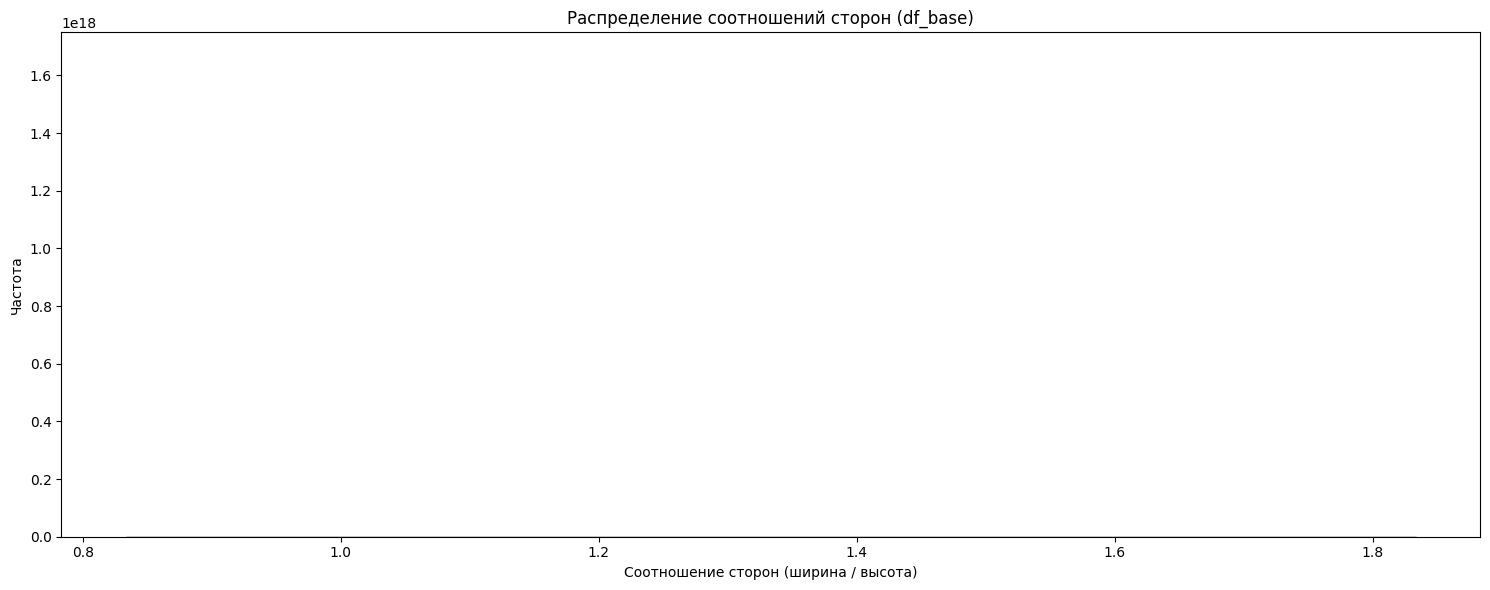

In [ ]:
# Создаём графики
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Гистограмма для df_enhanced
sns.histplot(df_base["aspect_ratio"], bins=30, ax=axes, kde=True, color="red")
axes.set_title("Распределение соотношений сторон (df_base)")
axes.set_xlabel("Соотношение сторон (ширина / высота)")
axes.set_ylabel("Частота")

plt.tight_layout()
plt.show()

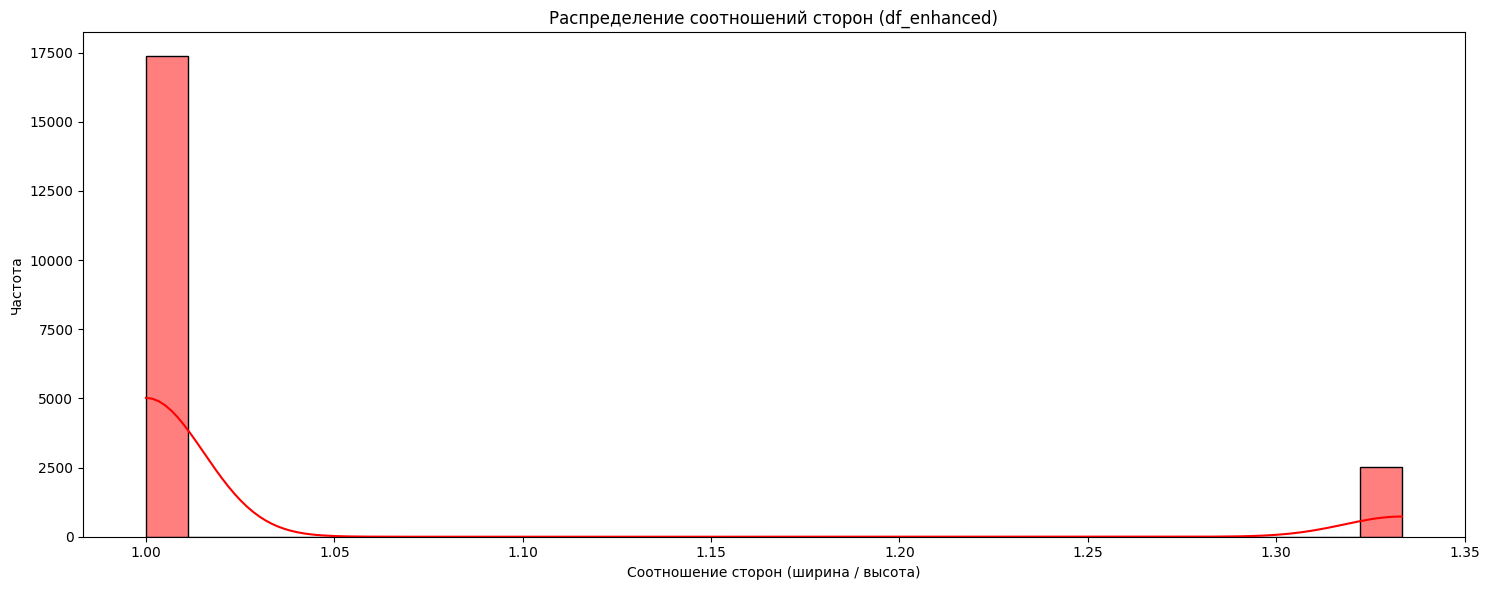

In [ ]:
# Создаём графики
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Гистограмма для df_enhanced
sns.histplot(df_enhanced["aspect_ratio"], bins=30, ax=axes, kde=True, color="red")
axes.set_title("Распределение соотношений сторон (df_enhanced)")
axes.set_xlabel("Соотношение сторон (ширина / высота)")
axes.set_ylabel("Частота")

plt.tight_layout()
plt.show()

* Минимальное соотношение сторон: 1
* Максимальное соотношение сторон: 1.3333333333333333
* Среднее соотношение сторон: 1.042345

**Вывод: Если распределение сильно разнится, может потребоваться изменение пропорций (например, паддинг).**

### 5. Гистограммы яркости и контраста. Чтобы понять, нужно ли делать нормализацию или аугментацию

#### Функции для вычисления яркости и контраста

In [ ]:
def compute_brightness_contrast(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert("L")  # Переводим в градации серого
    stat = ImageStat.Stat(img)
    brightness = stat.mean[0]
    contrast = stat.stddev[0]
    return brightness, contrast

In [ ]:
def add_brightness_contrast(df):
    df[["brightness", "contrast"]] = df["image"].apply(
        lambda x: pd.Series(compute_brightness_contrast(x["bytes"]))
    )
    return df

#### Вычисляем

In [ ]:
df_base = add_brightness_contrast(df_base)

In [ ]:
df_enhanced = add_brightness_contrast(df_enhanced)

#### Строим графики

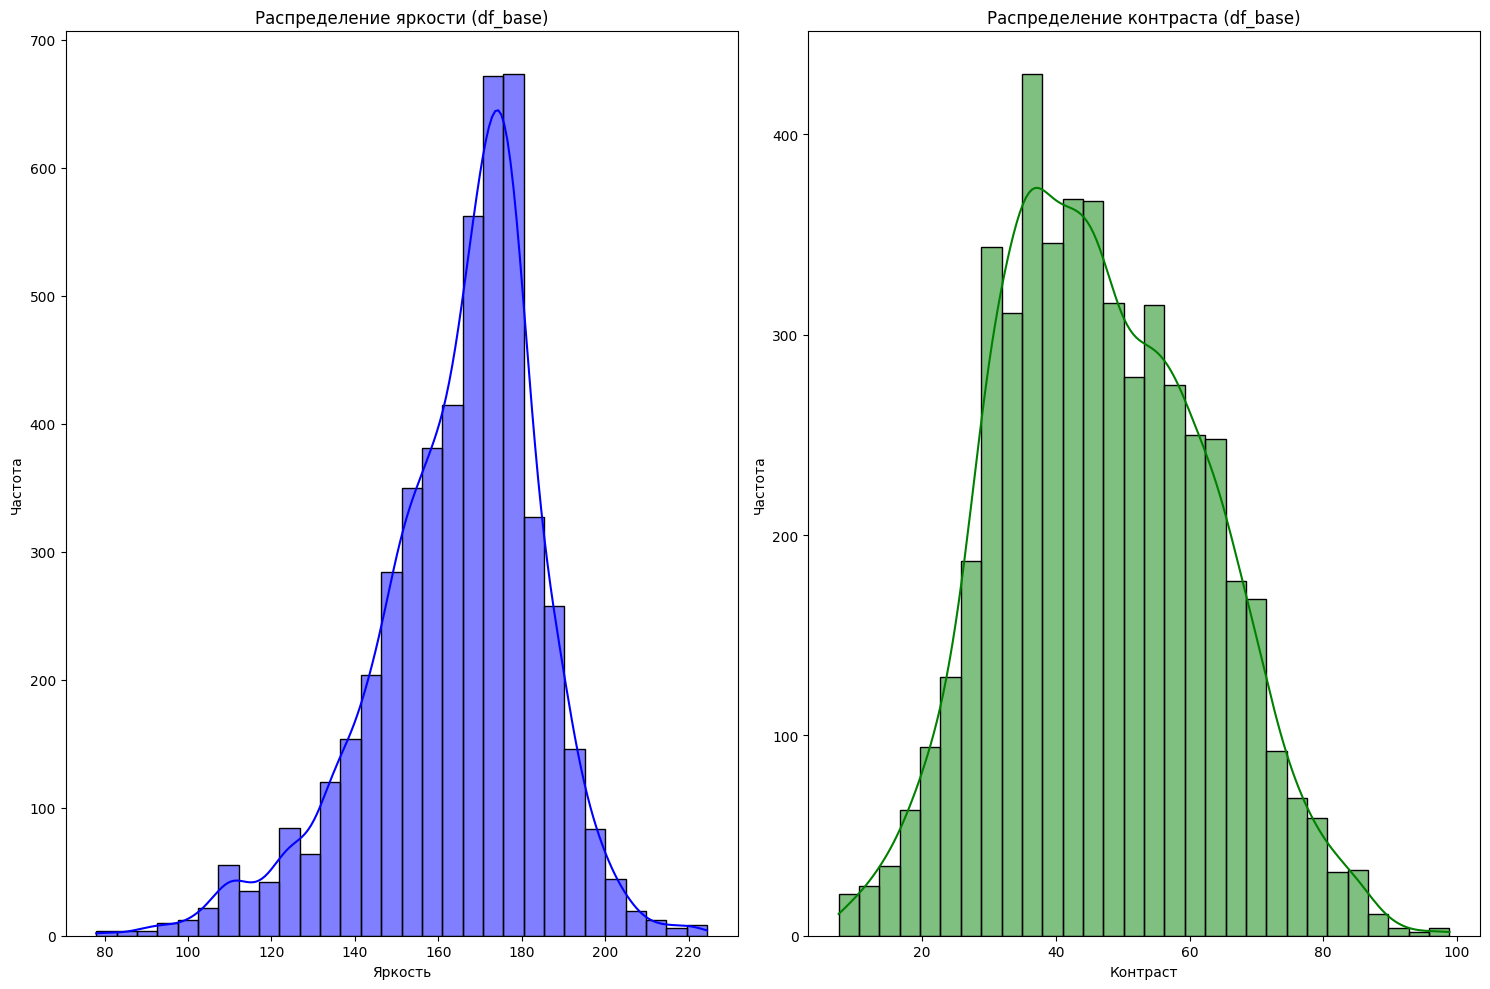

In [ ]:
# Строим гистограммы
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Яркость для df_base
sns.histplot(df_base["brightness"], bins=30, ax=axes[0], kde=True, color="blue")
axes[0].set_title("Распределение яркости (df_base)")
axes[0].set_xlabel("Яркость")
axes[0].set_ylabel("Частота")

# Контраст для df_base
sns.histplot(df_base["contrast"], bins=30, ax=axes[1], kde=True, color="green")
axes[1].set_title("Распределение контраста (df_base)")
axes[1].set_xlabel("Контраст")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# Строим гистограммы
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Яркость для df_enhanced
sns.histplot(df_enhanced["brightness"], bins=30, ax=axes[0], kde=True, color="red")
axes[0].set_title("Распределение яркости (df_enhanced)")
axes[0].set_xlabel("Яркость")
axes[0].set_ylabel("Частота")

# Контраст для df_enhanced
sns.histplot(df_enhanced["contrast"], bins=30, ax=axes[1], kde=True, color="purple")
axes[1].set_title("Распределение контраста (df_enhanced)")
axes[1].set_xlabel("Контраст")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

**Вывод: Низкий контраст или неравномерная яркость могут ухудшить результаты модели.**

### 6. Boxplot для анализа медианы, квартилей, выбросов. Чтобы увидеть выбросы в яркости и контрасте. Это поможет в выборе техник нормализации

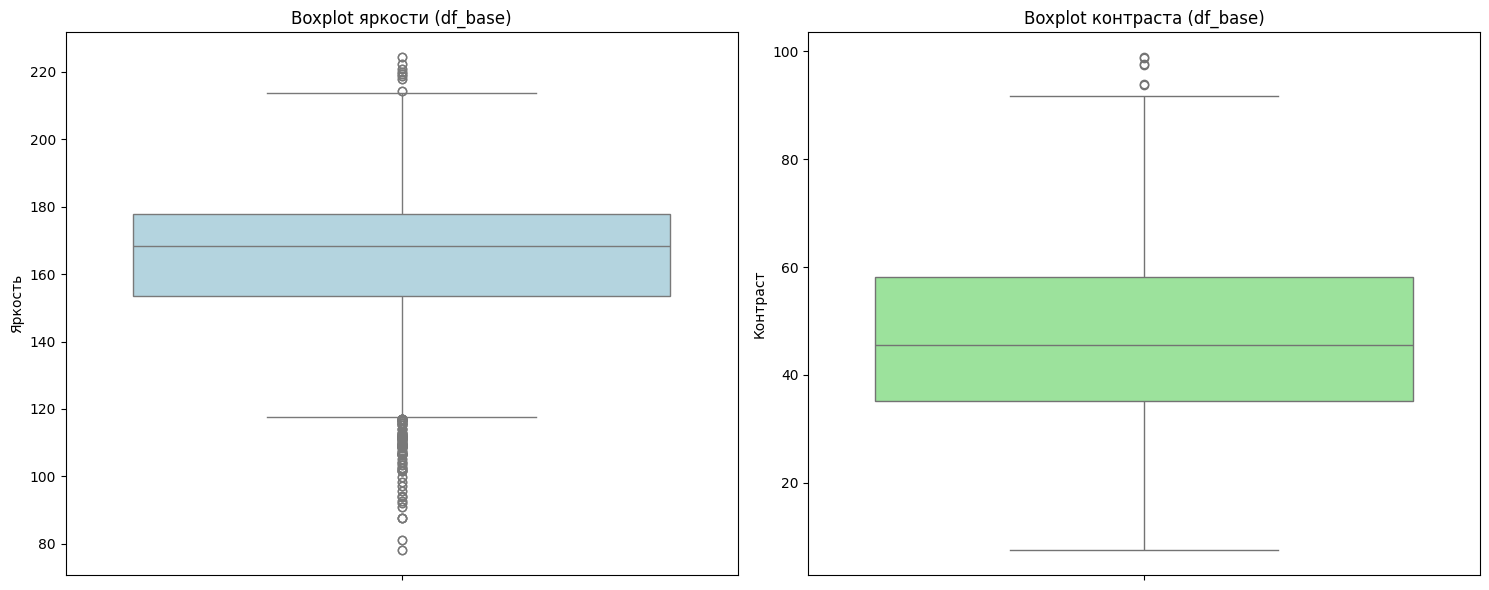

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(y=df_base["brightness"], ax=axes[0], color="lightblue")
axes[0].set_title("Boxplot яркости (df_base)")
axes[0].set_ylabel("Яркость")

sns.boxplot(y=df_base["contrast"], ax=axes[1], color="lightgreen")
axes[1].set_title("Boxplot контраста (df_base)")
axes[1].set_ylabel("Контраст")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(y=df_enhanced["brightness"], ax=axes[0], color="lightcoral")
axes[0].set_title("Boxplot яркости (df_enhanced)")
axes[0].set_ylabel("Яркость")

sns.boxplot(y=df_enhanced["contrast"], ax=axes[1], color="lightpink")
axes[1].set_title("Boxplot контраста (df_enhanced)")
axes[1].set_ylabel("Контраст")

plt.tight_layout()
plt.show()

**Вывод: Если выбросов много, нужно будет применить clipping (обрезку значений) или другие техники нормализации.**

### 7. Гистограммы по каналам RGB. Проверить наличие цветовых искажений.

#### Функция для вычисления гистограмм по каналам RGB

In [ ]:
def compute_rgb_histograms(df):
    r_values, g_values, b_values = [], [], []

    for _, row in df.iterrows():
        img = Image.open(io.BytesIO(row["image"]["bytes"]))
        r, g, b = img.convert("RGB").split()  # Разделяем на каналы

        # Добавляем значения в списки
        r_values.extend(np.array(r).flatten())
        g_values.extend(np.array(g).flatten())
        b_values.extend(np.array(b).flatten())

    return r_values, g_values, b_values

#### Вычисляем гистограммы

In [ ]:
r_base, g_base, b_base = compute_rgb_histograms(df_base)

In [ ]:
r_enh, g_enh, b_enh = compute_rgb_histograms(df_enhanced)

NameError: name 'compute_rgb_histograms' is not defined

#### Строим графики

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(r_base, bins=30, ax=axes[0], color="red", kde=True)
axes[0].set_title("Распределение канала R (df_base)")
axes[0].set_xlabel("Интенсивность (0-255)")
axes[0].set_ylabel("Частота")

sns.histplot(g_base, bins=30, ax=axes[1], color="green", kde=True)
axes[1].set_title("Распределение канала G (df_base)")
axes[1].set_xlabel("Интенсивность (0-255)")
axes[1].set_ylabel("Частота")

sns.histplot(b_base, bins=30, ax=axes[2], color="blue", kde=True)
axes[2].set_title("Распределение канала B (df_base)")
axes[2].set_xlabel("Интенсивность (0-255)")
axes[2].set_ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(r_enh, bins=30, ax=axes[0], color="red", kde=True)
axes[0].set_title("Распределение канала R (df_enhanced)")
axes[0].set_xlabel("Интенсивность (0-255)")
axes[0].set_ylabel("Частота")

sns.histplot(g_enh, bins=30, ax=axes[1], color="green", kde=True)
axes[1].set_title("Распределение канала G (df_enhanced)")
axes[1].set_xlabel("Интенсивность (0-255)")
axes[1].set_ylabel("Частота")

sns.histplot(b_enh, bins=30, ax=axes[2], color="blue", kde=True)
axes[2].set_title("Распределение канала B (df_enhanced)")
axes[2].set_xlabel("Интенсивность (0-255)")
axes[2].set_ylabel("Частота")

**Вывод: Если один канал доминирует, это может быть артефактом съемки.**

### 8. Гистограммы текстурных характеристик, таких как энтропия. Чтобы понять, сложны ли текстуры объектов. Это важно для подбора архитектуры модели (например, сверточных слоев).

* Минимальная энтропия: 5.218394438085534
* Максимальная энтропия: 7.668492245571787
* Средняя энтропия: 6.918846986852299

**Вывод: Высокая энтропия указывает на сложные текстуры, требующие более глубоких сетей.**